## Australian Rainfall Data Download and Exploratory Data Analysis

Attribution: code adapted from DSCI 525 lecture notes.

#### 1. Imports 

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np

#### 2. Downloading data using figshare API

In [2]:
# Necessary metadata
article_id = 14096681  # unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]             
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [9]:
%%time
files_to_dl = ["data.zip"]  
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 6.01 s, sys: 7.1 s, total: 13.1 s
Wall time: 2min 57s


In [10]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 17.5 s, sys: 2.35 s, total: 19.8 s
Wall time: 20.7 s


#### 3. Combining data files into one CSV file

In [13]:
%%time
## here we are using a normal python way for merging the data 
import pandas as pd
use_cols = ["time", "lat_min", "lat_max", "lon_min","lon_max","rain (mm/day)"]
files = glob.glob('figsharerainfall/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0, usecols=use_cols)
                .assign(model=re.findall(r"[\/|\\](.*)_daily_rainfall", file)[0])
                for file in files)
              )
df.to_csv("figsharerainfall/combined_data.csv")

CPU times: user 5min 48s, sys: 17.7 s, total: 6min 6s
Wall time: 6min 20s


In [14]:
%%sh
du -sh figsharerainfall/combined_data.csv

5.6G	figsharerainfall/combined_data.csv


In [15]:
%%time
df.head()

CPU times: user 280 µs, sys: 714 µs, total: 994 µs
Wall time: 1.27 ms


,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


##### 3.1 Comparing run times on different machines 

- We used pandas to concatenate the files in data.zip folder to a combined file which is 5.6GB in size.
- ** ADD A GENERAL OBSERVATION OF RUN TIMES AMONG THE GROUP MEMBERS**
- ** If anyone runs into issue, specify here...**

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken to combine files |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arlin   |      MacOS Monterey|  16GB   | 2 GHz Quad-Core Intel Core i5          |    No    |   CPU Time: 5 min 52s; Total: 6 min 9s; Wall time: 6 min 20s
| Artan   |      Windows 10    |  8GB   |   1.80 GHz Intel Core i5                |    Yes    |      CPU times: total: 9min 4s; Wall time: 9min 28s      |
| Shi Yan |      Windows 10    |  8GB   |   1.50 GHz Intel Core i5                |    Yes    |      CPU times: total: 10min 23s; Wall time: 10min 11s      |


#### 4. Load the combined CSV to memory and perform a simple EDA

EDA question: Perform value counts on a float variable `lat_min`.

##### 4.1 Regular Loading

In [2]:
%%time
# Load time
df = pd.read_csv("figsharerainfall/combined_data.csv")

CPU times: total: 1min 34s
Wall time: 1min 54s


In [3]:
%%time
# Simple EDA
counts = df["lat_min"].value_counts()

CPU times: total: 1.25 s
Wall time: 1.29 s


##### 4.2 Changing Data Type

In [4]:
%%time
# Load time
df_16 = pd.read_csv("figsharerainfall/combined_data.csv", dtype={"lat_min": np.float16,
                                                              "lat_max": np.float16,
                                                              "lon_min": np.float16,  
                                                              "lon_max": np.float16,
                                                              "rain (mm/day)": np.float16})

CPU times: total: 1min 19s
Wall time: 1min 22s


In [5]:
# Comparing memory space between datatype64GB and 16GB
print(f"DataFrame with numeric columns as float16: {df_16.memory_usage().sum() / 1e6:.2f} GB")
print(f"DataFrame with numeric columns as float64: {df.memory_usage().sum() / 1e6:.2f} GB")

DataFrame with numeric columns as float16: 1624.16 GB
DataFrame with numeric columns as float64: 3498.20 GB


In [6]:
%%time
# Simple EDA
counts = df_16["lat_min"].value_counts()

CPU times: total: 1.05 s
Wall time: 1.04 s


##### 4.3 Load Selected Columns Only

In [7]:
%%time
# Load time
df = pd.read_csv("figsharerainfall/combined_data.csv", usecols=["lat_min","lat_max", "rain (mm/day)"])

CPU times: total: 53.2 s
Wall time: 59.6 s


In [8]:
%%time
# Simple EDA
counts = df["lat_min"].value_counts()

CPU times: total: 766 ms
Wall time: 782 ms


##### 4.4 Loading in Chunks

In [9]:
%%time
# Load and EDA time
chunk_counts = pd.Series(dtype=np.float16)
for chunk in pd.read_csv("figsharerainfall/combined_data.csv", chunksize=10_000_000):
    chunk_counts.add(chunk["lat_min"].value_counts(), 
                     fill_value=None)  # To exclude NaN
chunk_counts.head()

CPU times: total: 1min 14s
Wall time: 1min 14s


Series([], dtype: float16)

##### 4.5 Loading with Dask

In [10]:
%%time
# Load time
import dask.dataframe as dd
df_dask = dd.read_csv("figsharerainfall/combined_data.csv")

CPU times: total: 766 ms
Wall time: 2.16 s


In [11]:
%%time
#computing values of lat_min variable 
df_dask["lat_min"].value_counts().compute()

CPU times: total: 1min 21s
Wall time: 23 s


-31.099476    3035329
-32.984293    3035329
-34.869110    3035329
-32.041885    3035329
-30.000000    1747830
               ...   
-30.696652     183960
-36.277805     183960
-36.281964     183960
-30.700015     183960
-33.487232     183960
Name: lat_min, Length: 84, dtype: int64

##### 4.6 Comparing CPU Time of Different Machines

| Team Member | Task  |  Regular Loading |      Changed Data Type |      Selected Columns |  Chunks            |   Dask        |
|:-----------:|:------|:----------------:|:----------------------:|:---------------------:|:------------------:|:-------------:|
| Arlin       | Load  |       56s        |          54.6s         |           31s         |load + EDA:57.3s    |     10.5 ms   | 
|             | EDA   |       686ms      |             747ms      |            946ms      |included above      |      37.6s    |
| Artan       | Load  |    1min 34s      |        1min 19s        |       53.2 s          |load + EDA: 1min 14s|    766 ms     |
|             | EDA   |       1.25 s     |        1.05 s          |       766 ms          |included above      |    1min 21s   |
| Shi Yan     | Load  |    2min 33s      |        2min 12s        |       1min 27s        |load + EDA: 3min 14s|    23.35 s    |
|             | EDA   |       7.14 s     |         14.03 s        |       9.76 s          |included above      |    2min 3s    |

>Observations: Artan's laptop did not have problem loading the csv files but was getting errors like the below when doing an EDA including calculating mean values per model:
>```Python
>MemoryError: Unable to allocate 477. MiB for an array with shape (1, 62467843) and data type object
>```


>Shi Yan's laptop got the same memory error, operations also took longer time.

- Compared with the original dataframe float64 datatype, changing to float16 reduced the memory space of the dataframe from 3498.20 GB to 1624.16GB. Performing value_counts() EDA on the column `lat_min` was _______ for float16 than for float64.
- Doubling the RAM size from 8GB to 16GB would boost the performance more than two times.
- summary about dask vs. regular loading in pandas

#### 6. Perform a simple EDA in R

In [2]:
# Limit dataset to cover two models with time-saving
df = pd.read_csv("figsharerainfall/combined_data.csv", nrows=2000000)

In [3]:
# Load the ipython extension that provides the %%R cell magic
%load_ext rpy2.ipython

C:\Users\proeu\miniconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


##### 6.1 Transfer the dataframe from python to R

##### Pandas Exchange

In [4]:
%%time
%%R -i df
start_time <- Sys.time()
end_time <- Sys.time()
head(df)
print(end_time - start_time)

Time difference of 0 secs
CPU times: total: 1min 17s
Wall time: 1min 18s


##### Parquet file

In [5]:
df.to_parquet("figsharerainfall/combined_data.parquet")

In [6]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(tidyverse, warn.conflicts = FALSE))

In [7]:
%%time
%%R
ds <- open_dataset("figsharerainfall/combined_data.parquet")
so <- Scanner$create(ds)
at <- so$ToTable()
df <- as.data.frame(at)
head(df)

# A tibble: 6 x 7
  time                lat_min lat_max lon_min lon_max `rain (mm/day)` model     
  <chr>                 <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>     
1 1889-01-01 12:00:00   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-1~
2 1889-01-02 12:00:00   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-1~
3 1889-01-03 12:00:00   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-1~
4 1889-01-04 12:00:00   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-1~
5 1889-01-05 12:00:00   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-1~
6 1889-01-06 12:00:00   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-1~
CPU times: total: 1.55 s
Wall time: 1.63 s


**Approach discussion**

|     Approach    | CPU Time  | Wall Time |
|:---------------:|:----------|:---------:|
| Pandas Exchange | 1min 24s  |  1min 25s | 
| Parquet file    |  1.55 s   |    1.78 s |

> Two approaches are explored here: Pandas Exchange and Parquet file.

Both methods have its own advantages:

`Pandas exchange` - Easy and simple, the goal can be achieved by one-line code.
`Parquet file` - Require more code lines but not heavy. The benefit of running time is significant.

> As a team, we decided to use `Parquet file` for its time efficiency. This is important when working with large datasets.

##### EDA

In [8]:
%%R
# To see models covered by the dataset
models <- unique(df$model)
models

[1] "MPI-ESM-1-2-HAM" "AWI-ESM-1-1-LR"  "NorESM2-LM"     


In [17]:
%%R
# Wrangling
df$time <- as.Date(df$time)
df$year <- format(as.Date(df$time, format = "%d/%m/%Y"),"%Y")
# Only cover two models for comparison
df <- subset(df, (model == "MPI-ESM-1-2-HAM" | model == "AWI-ESM-1-1-LR"))
df_year <- aggregate(df$`rain (mm/day)`, by=list(df$year, df$model), FUN = sum)
names(df_year)[names(df_year) == "Group.1"] <- "year"
names(df_year)[names(df_year) == "Group.2"] <- "model"
names(df_year)[names(df_year) == "x"] <- "rain"
head(df_year)

  year          model     rain
1 1889 AWI-ESM-1-1-LR 17481.37
2 1890 AWI-ESM-1-1-LR 15292.96
3 1891 AWI-ESM-1-1-LR 12395.85
4 1892 AWI-ESM-1-1-LR 10460.87
5 1893 AWI-ESM-1-1-LR 16845.34
6 1894 AWI-ESM-1-1-LR 15931.97


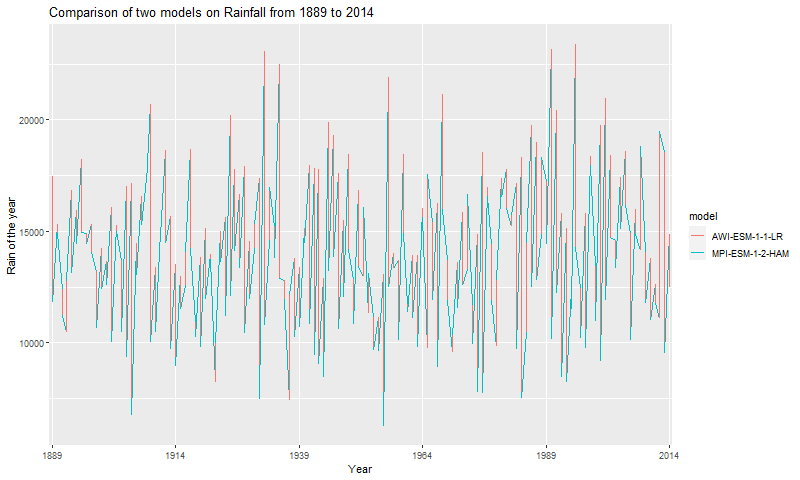

In [20]:
%%R -w 800
# To compare trendlines of two models
ggplot(df_year, aes(x = year, y = rain, color = model, group=1)) +
    geom_line() + labs(y='Rain of the year', x='Year') +
    scale_x_discrete(breaks=c(1889, 1914, 1939, 1964, 1989, 2014)) +
    ggtitle("Comparison of two models on Rainfall from 1889 to 2014")